In [1]:
# Initialize: import libraries

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, GridSearchCV


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv


# 1. Import and clean data

In [3]:
raw_data = pd.read_csv('/kaggle/input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv')
df = raw_data.copy(deep=True)
df

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,Placed,400000.0
211,212,M,58.00,Others,60.00,Others,Science,72.00,Sci&Tech,No,74.0,Mkt&Fin,53.62,Placed,275000.0
212,213,M,67.00,Others,67.00,Others,Commerce,73.00,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,Placed,295000.0
213,214,F,74.00,Others,66.00,Others,Commerce,58.00,Comm&Mgmt,No,70.0,Mkt&HR,60.23,Placed,204000.0


Get to know features.
* **sl_no** : Serial Number
* **ssc_p** : Secondary Education percentage- 10th Grade
* **ssc_b** : Board of Education
* **hsc_p** : Higher Secondary Education percentage- 12th Grade
* **hsc_b** : Board of Education
* **hsc_s** : Specialization in Higher Secondary Education
* **degree_p** : Degree Percentage
* **degree_t** : Under Graduation(Degree type)
* **etest_p** : Employability test percentage ( conducted by college)
* **mba_p** : Post Graduation(MBA)- Specialization
* **status** : Status of placement

In [4]:
# Check missing data

def missing_data(df):
        total = df.isnull().sum().sort_values(ascending=False)
        percent_1 = df.isnull().sum()/df.isnull().count()*100
        percent_2 = (round(percent_1,1)).sort_values(ascending=False)
        percent_3 = df.count()
        missing_table = pd.concat([total,percent_2,percent_3],axis=1,keys=['Null','%','Count'])
        return(missing_table)
display(pd.concat([missing_data(df),pd.concat([df.dtypes,df.nunique()],axis = 1,keys = ['Type','Unique'])],axis = 1))

,Null,%,Count,Type,Unique
salary,67,31.2,148,float64,45
sl_no,0,0.0,215,int64,215
gender,0,0.0,215,object,2
ssc_p,0,0.0,215,float64,103
ssc_b,0,0.0,215,object,2
hsc_p,0,0.0,215,float64,97
hsc_b,0,0.0,215,object,2
hsc_s,0,0.0,215,object,3
degree_p,0,0.0,215,float64,89
degree_t,0,0.0,215,object,3


67 null values are founded in salaray column

In [5]:
# Check Duplicate rows

duplicateRows = df[df.duplicated()]
duplicateRows

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary


In [6]:
# check if salary of Not Placed status always equals NaN

rslt_df = df[df['salary'].isna()]
rslt_df['status'].value_counts()

## salary of not placed always = NaN, not missinge at random

Not Placed    67
Name: status, dtype: int64

67 of 67 NaN Salary are unemployed, therefore we can conclude that they are not missing at random, salary of Not Placed status always equals NaN.
Let fill them with 0

In [7]:
# We impute NaN in salary with 0 since they are unhired

df['salary'].fillna(value=0, inplace=True)
display(pd.concat([missing_data(df),pd.concat([df.dtypes,df.nunique()],axis = 1,keys = ['Type','Unique'])],axis = 1))

,Null,%,Count,Type,Unique
sl_no,0,0.0,215,int64,215
gender,0,0.0,215,object,2
ssc_p,0,0.0,215,float64,103
ssc_b,0,0.0,215,object,2
hsc_p,0,0.0,215,float64,97
hsc_b,0,0.0,215,object,2
hsc_s,0,0.0,215,object,3
degree_p,0,0.0,215,float64,89
degree_t,0,0.0,215,object,3
workex,0,0.0,215,object,2


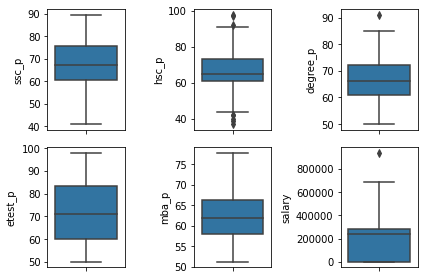

In [8]:
# Check for outlier for numeric data

fig,saxis = plt.subplots(2,3)
sns.boxplot(y = df.ssc_p,ax = saxis[0,0])
sns.boxplot(y = df.hsc_p,ax = saxis[0,1])
sns.boxplot(y = df.degree_p,ax = saxis[0,2])
sns.boxplot(y = df.etest_p,ax = saxis[1,0])
sns.boxplot(y = df.mba_p,ax = saxis[1,1])
sns.boxplot(y = df.salary,ax = saxis[1,2])
plt.tight_layout()  # add padding between subplots to avoid overlapping



outliers found in 3 columns: hsc_p, degree_p and salary

In [9]:
# eliminate outliers using IQR method

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  import sys


,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,0.0
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,Placed,400000.0
211,212,M,58.00,Others,60.00,Others,Science,72.00,Sci&Tech,No,74.0,Mkt&Fin,53.62,Placed,275000.0
212,213,M,67.00,Others,67.00,Others,Commerce,73.00,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,Placed,295000.0
213,214,F,74.00,Others,66.00,Others,Commerce,58.00,Comm&Mgmt,No,70.0,Mkt&HR,60.23,Placed,204000.0


10 rows have beed excluded from df

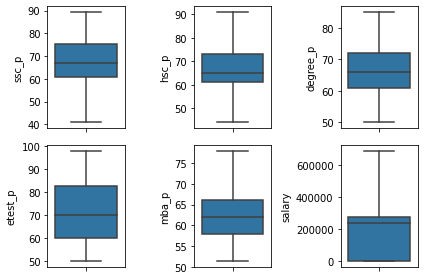

In [10]:
# Check for outlier for numeric data

fig,saxis = plt.subplots(2,3)
sns.boxplot(y = df.ssc_p,ax = saxis[0,0])
sns.boxplot(y = df.hsc_p,ax = saxis[0,1])
sns.boxplot(y = df.degree_p,ax = saxis[0,2])
sns.boxplot(y = df.etest_p,ax = saxis[1,0])
sns.boxplot(y = df.mba_p,ax = saxis[1,1])
sns.boxplot(y = df.salary,ax = saxis[1,2])
plt.tight_layout()  # add padding between subplots to avoid overlapping

Now we are ready for EDA.

# 2. Exploratory Data Analysis (EDA) 

In [11]:
# define categorical and numerical columns

catCols = [col for col in df.columns if df[col].dtype=="O"]
numCols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

print(catCols)
print(numCols)

['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation', 'status']
['sl_no', 'ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'salary']


## Countplot

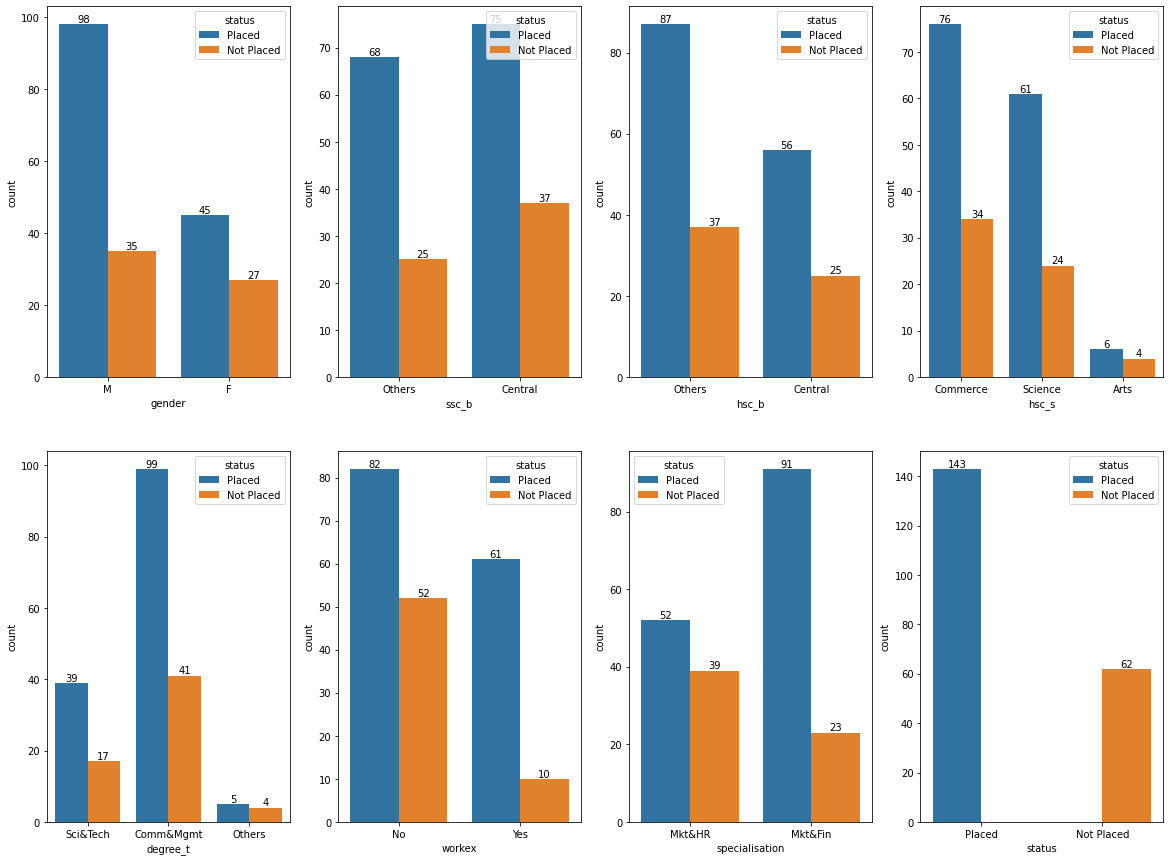

In [12]:
# Check relationship between categorical features and 'status'

fig,ax = plt.subplots(2, 4, figsize = (20,15))
row,col = -1,0

for i,var in enumerate(df[catCols]):
    if i%4==0:
        row += 1
        col = 0

    aa = sns.countplot(data=df, x=var, hue='status', ax=ax[row,col])
    aa.bar_label(aa.containers[0])
    aa.bar_label(aa.containers[1])
    col += 1
    
plt.show()

* **Gender**: If looking at the percentage, more female is unhired compare to male
* **Specilisation**: More job opportunity in marketing and financial.
* **Work Experience**: People with work experience have a good chance to be employed


## Violinplot

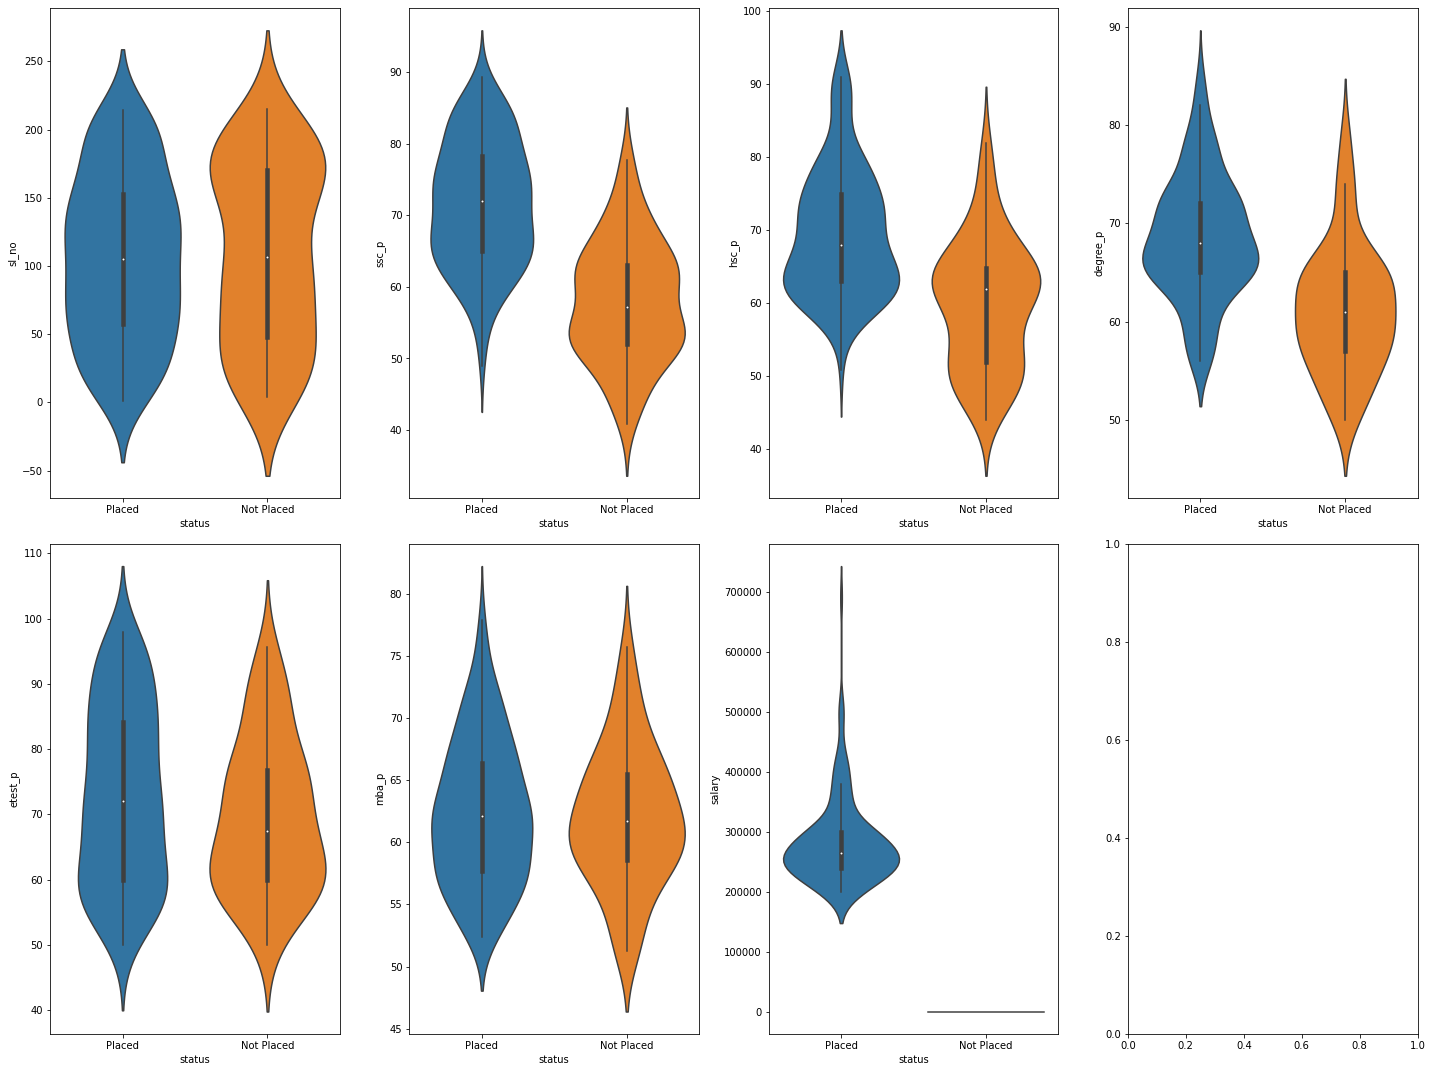

In [13]:
# Check relationship between numerical features and 'status'


fig,ax = plt.subplots(2, 4, figsize = (20,15))
row,col = -1,0

for i,var in enumerate(df[numCols]):
    if i%4==0:
        row += 1
        col = 0

    aa = sns.violinplot(data=df, x='status', y=var, ax=ax[row,col])

    col += 1
    
plt.tight_layout()  # add padding between subplots to avoid overlapping
plt.show()



It is clearly seen that **ssc_p**, **hsc_p** and **degree_p** are more important factor for employment compare to **etest_p** and **mba_p**.

In [14]:
# Encode data for correlation matrix

label = LabelEncoder()
df_encode = df.copy(deep=True)

for col in catCols:
        df_encode[col+'_code'] = label.fit_transform(df_encode[col])

# Drop Encoded 
df_encode.drop(catCols,axis=1,inplace =True)
df_encode.head()

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary,gender_code,ssc_b_code,hsc_b_code,hsc_s_code,degree_t_code,workex_code,specialisation_code,status_code
0,1,67.00,91.00,58.00,55.0,58.80,270000.0,1,1,1,1,2,0,1,1
1,2,79.33,78.33,77.48,86.5,66.28,200000.0,1,0,1,2,2,1,0,1
2,3,65.00,68.00,64.00,75.0,57.80,250000.0,1,0,0,0,0,0,0,1
3,4,56.00,52.00,52.00,66.0,59.43,0.0,1,0,0,2,2,0,1,0
4,5,85.80,73.60,73.30,96.8,55.50,425000.0,1,0,0,1,0,0,0,1


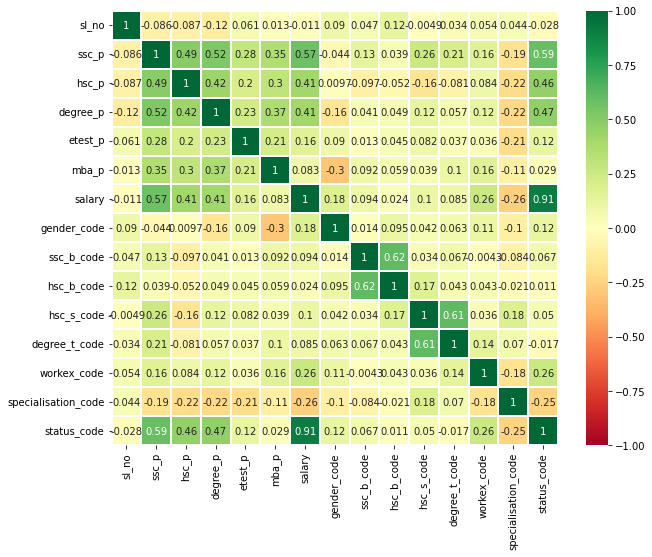

In [15]:
sns.heatmap(df_encode.corr(), vmin=-1, vmax=1, center=0, annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

Top significant features are **salary**, **ssc_p**, **degree_p** and **hsc_p**, respectively.
However, new graduated earns **salary** afer getting a job. In real world, we know salary after get hired.
In this sense, we have to drop **salary**.

# 3. Data Preprocessing

In [16]:
# perfrom labelEncoder and oneHotEncoder

label = LabelEncoder()
df_dummy = df.copy(deep=True)

df_dummy['status'] = label.fit_transform(df_dummy['status'])

catCols = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation'] # catCols without 'status'


# encoding the categorical columns
df_dummy = pd.get_dummies(df_dummy, columns = catCols, drop_first = True)


df_dummy

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,status,salary,gender_M,ssc_b_Others,hsc_b_Others,hsc_s_Commerce,hsc_s_Science,degree_t_Others,degree_t_Sci&Tech,workex_Yes,specialisation_Mkt&HR
0,1,67.00,91.00,58.00,55.0,58.80,1,270000.0,1,1,1,1,0,0,1,0,1
1,2,79.33,78.33,77.48,86.5,66.28,1,200000.0,1,0,1,0,1,0,1,1,0
2,3,65.00,68.00,64.00,75.0,57.80,1,250000.0,1,0,0,0,0,0,0,0,0
3,4,56.00,52.00,52.00,66.0,59.43,0,0.0,1,0,0,0,1,0,1,0,1
4,5,85.80,73.60,73.30,96.8,55.50,1,425000.0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,80.60,82.00,77.60,91.0,74.49,1,400000.0,1,1,1,1,0,0,0,0,0
211,212,58.00,60.00,72.00,74.0,53.62,1,275000.0,1,1,1,0,1,0,1,0,0
212,213,67.00,67.00,73.00,59.0,69.72,1,295000.0,1,1,1,1,0,0,0,1,0
213,214,74.00,66.00,58.00,70.0,60.23,1,204000.0,0,1,1,1,0,0,0,0,1


In [17]:
# drop irrevant columns

df_dummy.drop(['sl_no', 'salary'],axis=1,inplace =True)
df_dummy

,ssc_p,hsc_p,degree_p,etest_p,mba_p,status,gender_M,ssc_b_Others,hsc_b_Others,hsc_s_Commerce,hsc_s_Science,degree_t_Others,degree_t_Sci&Tech,workex_Yes,specialisation_Mkt&HR
0,67.00,91.00,58.00,55.0,58.80,1,1,1,1,1,0,0,1,0,1
1,79.33,78.33,77.48,86.5,66.28,1,1,0,1,0,1,0,1,1,0
2,65.00,68.00,64.00,75.0,57.80,1,1,0,0,0,0,0,0,0,0
3,56.00,52.00,52.00,66.0,59.43,0,1,0,0,0,1,0,1,0,1
4,85.80,73.60,73.30,96.8,55.50,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,80.60,82.00,77.60,91.0,74.49,1,1,1,1,1,0,0,0,0,0
211,58.00,60.00,72.00,74.0,53.62,1,1,1,1,0,1,0,1,0,0
212,67.00,67.00,73.00,59.0,69.72,1,1,1,1,1,0,0,0,1,0
213,74.00,66.00,58.00,70.0,60.23,1,0,1,1,1,0,0,0,0,1


In [18]:
# Define Target and Features

target = ['status']
y = df_dummy[target ]
X = df_dummy.drop(target , axis=1)

Since **ssc_p, degree_p, etest_p, mba_p** and **hsc_p** are scaling as percentage (min=0, max=100), it is not necessary to normalize them.

In [19]:
# Split data

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.15, random_state=3)
X_train.shape

(174, 14)

# 4. Model

In [20]:
# Define prediction models

models = [
         #Decision Tree:
         ('dt',DecisionTreeClassifier()),
    
         #Ensemble Methods:
         ('rfc',RandomForestClassifier(random_state=42)),

         #GLM: 
         ('lr',LogisticRegression(max_iter=5000)),
                
         #Navies Bayes:
         ('gnb',GaussianNB()),
                
         #Nearest Neighbor:
         ('knn',KNeighborsClassifier()),
                
         #SVM:
         ('svc',SVC(probability=True)),
                
         #xgboost:
         ('xgb',XGBClassifier())

]

In [21]:
# Run and compare models

kfold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

Model_columns = ['Model Name', 'Model Train Accuracy Mean','Model Test Accuracy Mean','std','Model Time']# ,'Model Parameters'
Model_compare = pd.DataFrame(columns = Model_columns)

row_index = 0
for alg in models:
        model = alg[1]
                
        Model_name = model.__class__.__name__
        Model_compare.loc[row_index,'Model Name'] = Model_name

        #score model with cross validation: 
        cv_results = cross_validate(model, X_train, y_train.values.ravel(), cv = kfold, return_train_score=True, return_estimator=True)

        Model_compare.loc[row_index,'Model Time'] = cv_results['fit_time'].mean()
        Model_compare.loc[row_index,'Model Train Accuracy Mean'] = cv_results['train_score'].mean()
        Model_compare.loc[row_index,'Model Test Accuracy Mean'] = cv_results['test_score'].mean()
        Model_compare.loc[row_index,'std'] = cv_results['test_score'].std()*3#let's know the worst that can happen!
        row_index+=1


Model_compare.sort_values(by = ['Model Test Accuracy Mean'], ascending = False, inplace = True)
Model_compare

,Model Name,Model Train Accuracy Mean,Model Test Accuracy Mean,std,Model Time
2,LogisticRegression,0.877862,0.856303,0.094031,0.094563
1,RandomForestClassifier,1.0,0.850588,0.033384,0.110611
4,KNeighborsClassifier,0.870678,0.827731,0.119529,0.001848
6,XGBClassifier,1.0,0.80437,0.104339,0.152725
3,GaussianNB,0.818941,0.798824,0.143601,0.001899
0,DecisionTreeClassifier,1.0,0.770084,0.171618,0.002099
5,SVC,0.778726,0.770084,0.054807,0.004803


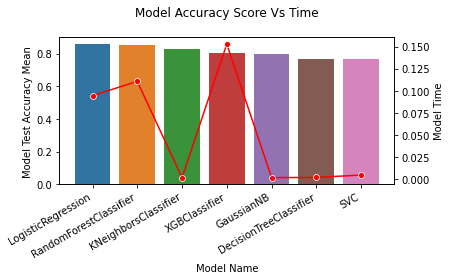

In [22]:
# Plot result

ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(6,3))
sns.barplot(y = 'Model Test Accuracy Mean', x = 'Model Name', data = Model_compare)

ax2 = ax1.twinx()

sns.lineplot(data = Model_compare,y = 'Model Time', x = 'Model Name', marker='o', sort = False, ax=ax2, color='red')

    
#prettify using pyplot
plt.title('Model Accuracy Score Vs Time\n')

plt.gcf().autofmt_xdate()
plt.show()

Logistic regression is the best model in this setting. Let see anything we can improve to deliver better result.

# 5. Improve Accuracy

## 5.1. GridSearchCV

In [23]:
param_grid = {"subsample":[0.75, 1],
              "max_depth":[4, 6, 8],
              "learning_rate":[0.1, 0.01],
              "n_estimators":[100,200]}


xgb = XGBClassifier(n_jobs=-1)
cv_xgb = GridSearchCV(model,param_grid=param_grid,cv=kfold,scoring="accuracy", verbose=1)
cv_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [24]:
print("best params : ", cv_xgb.best_params_)
print("accuracy : ",cv_xgb.best_score_)

best params :  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.75}
accuracy :  0.8332773109243699


We can see that the accuray of XGBClassifier increases from **0.804** to **0.833**.
However, it still slightly underperform comparing to LogisticRegression.

## 5.2. Feature Engineering
We will remove features with lowest significant, for example,  **ssc_b**, **hsc_b** and **hsc_s**

In [25]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

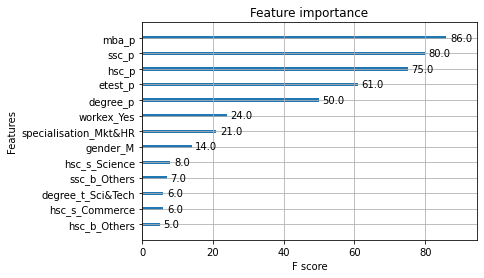

In [26]:

from xgboost import plot_importance

# Rank feature importance
plot_importance(xgb)


In [27]:
sig_col = ['mba_p', 'ssc_p', 'hsc_p', 'etest_p', 'degree_p', 'workex_Yes', 'specialisation_Mkt&HR', 'gender_M']
df_fea = df_dummy[sig_col].copy(deep=True)
df_fea

,mba_p,ssc_p,hsc_p,etest_p,degree_p,workex_Yes,specialisation_Mkt&HR,gender_M
0,58.80,67.00,91.00,55.0,58.00,0,1,1
1,66.28,79.33,78.33,86.5,77.48,1,0,1
2,57.80,65.00,68.00,75.0,64.00,0,0,1
3,59.43,56.00,52.00,66.0,52.00,0,1,1
4,55.50,85.80,73.60,96.8,73.30,0,0,1
...,...,...,...,...,...,...,...,...
210,74.49,80.60,82.00,91.0,77.60,0,0,1
211,53.62,58.00,60.00,74.0,72.00,0,0,1
212,69.72,67.00,67.00,59.0,73.00,1,0,1
213,60.23,74.00,66.00,70.0,58.00,0,1,0


In [28]:
lgr = LogisticRegression()

cv_results = cross_validate(lgr,X_train,y_train.values.ravel(),cv=kfold,n_jobs=-1,return_train_score=True)


In [29]:
print('avg train score = ',cv_results['train_score'].mean())
print('avg test score = ',cv_results['test_score'].mean())

avg train score =  0.8548920863309352
avg test score =  0.8389915966386555


Reducing dimension does not result in a positive way. We should stick with previous LogisticRegression model with accuracy = 0.856.